<a href="https://colab.research.google.com/github/lcanalesIA/lcanales_NeuroAI/blob/main/NeuroAI_lcanales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1 **Proyecto** Detección de hemorragia intracraneana (HIC) en tomografía computada (TC)



2 **Objetivo**: Clasificación binaria para detección de HIC en TC mediante un modelo CNN con fine tunning.

3 **Introducción**
      
  a. Contexto: La gran cantidad de estudios de imágenes médicas que se realizan a diario en los sitemas sanitarios obliga a priorizar la interpretación de aquellos que presentan hallazgos anormales críticos. En este sentido las hemorragias intracraneanas constituyen una emergencia médica, razón por la cual es perentorio su reconocimiento precoz tanto para el proceso diagnóstico-terapéutico como para la priorización dentro de listas de trabajo radiológicas extensas.

  b. Objetivo del modelo: Clasificación binaria para presencia o ausencia de HIC en TC de encéfalo para triage.

  c. Alcance: El modelo utiliza una red neuronal preentrenada en imágenes que mediante transfer learning se entrena para el reconocimiento de hemiorragias intracraneanas en tomografías computadas de encéfalo, supone alta sensibilidad para priorización.

FASE PRELIMINAR: Entorno y librerías

In [1]:
# @title
# 0) Entorno e instalaciones mínimas (ejecutar SOLO una vez si falta algo)
import sys, subprocess, pkgutil

# Función para asegurar que un paquete esté instalado
def asegurar(paquete, nombre_pip=None):
    if pkgutil.find_loader(paquete) is None:
        print(f'📦 {paquete} no encontrado, instalando {nombre_pip or paquete} ...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', nombre_pip or paquete])
    else:
        print(f'✅ {paquete} ya está instalado')

# Lista de paquetes a verificar (modulo, nombre_pip)
for modulo, nombre_pip in [
    ('torch', 'torch torchvision --index-url https://download.pytorch.org/whl/cu121'),
    ('pandas','pandas'), ('numpy','numpy'), ('matplotlib','matplotlib'),
    ('sklearn','scikit-learn'), ('pydicom','pydicom'), ('nibabel','nibabel'),
    ('cv2','opencv-python'), ('monai','monai'), ('pytorch_grad_cam','grad-cam')
]:
    asegurar(modulo, nombre_pip)

# Verificación final de PyTorch y GPU
import torch
print('🧪 PyTorch:', torch.__version__, '| CUDA disponible:', torch.cuda.is_available())

/tmp/ipython-input-196231607.py:7: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(paquete) is None:


✅ torch ya está instalado
✅ pandas ya está instalado
✅ numpy ya está instalado
✅ matplotlib ya está instalado
✅ sklearn ya está instalado
📦 pydicom no encontrado, instalando pydicom ...
✅ nibabel ya está instalado
✅ cv2 ya está instalado
📦 monai no encontrado, instalando monai ...
📦 pytorch_grad_cam no encontrado, instalando grad-cam ...
🧪 PyTorch: 2.8.0+cu126 | CUDA disponible: True


FASE: CONJUNTO DE DATOS

4 **Descripción del conjunto de datos**:
    a. Fuentes de datos: Se utiliza un dataset de acceso abierto (previo login) publicado por **PhysioNet** (https://doi.org/10.13026/4nae-zg36) que incluye 82 TC etiquetadas para presencia o ausencia de HIC. Corresponden a imágenes en formato NIfTI o estandar para tratamiento de neuroimágenes.


Configuración de rutas

Se preparan los datos cargados en Drive, se ejecuta código para descompresión y creación de carpetas de destino, estableciendo las rutas de acceso correspondientes.


In [2]:
# @title
# --- Colab: Montar Google Drive y preparar dataset ---
from pathlib import Path
import os, zipfile

# 1) Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Rutas
RUTA_ZIP = Path("/content/drive/MyDrive/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1.zip")
CARPETA_DATOS = Path("/content/ct_ich")  # se descomprime en el entorno de Colab

# 3) Crear carpeta destino
os.makedirs(CARPETA_DATOS, exist_ok=True)

# 4) Descomprimir solo si no existen archivos NIfTI
if not any(CARPETA_DATOS.rglob("*.nii*")):
    assert RUTA_ZIP.exists(), f"❌ No se encontró el archivo ZIP en: {RUTA_ZIP}"
    with zipfile.ZipFile(RUTA_ZIP, "r") as archivo_zip:
        archivo_zip.extractall(CARPETA_DATOS)
    print("✅ ZIP descomprimido en:", CARPETA_DATOS)
else:
    print("ℹ️ El conjunto de datos ya estaba descomprimido en:", CARPETA_DATOS)

# 5) Verificación de estructura
nii_files = list(CARPETA_DATOS.rglob("*.nii*"))
print(f"📦 Archivos NIfTI encontrados: {len(nii_files)}")
if nii_files[:5]:
    print("🔎 Ejemplos:", nii_files[:5])

Mounted at /content/drive
✅ ZIP descomprimido en: /content/ct_ich
📦 Archivos NIfTI encontrados: 150
🔎 Ejemplos: [PosixPath('/content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/090.nii'), PosixPath('/content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/096.nii'), PosixPath('/content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/105.nii'), PosixPath('/content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/110.nii'), PosixPath('/content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/078.nii')]


In [3]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Verificación de archivos

In [4]:
# @title
from pathlib import Path

# Usamos la carpeta donde se descomprimió el dataset
archivos_nii = list(Path(CARPETA_DATOS).rglob("*.nii*"))

print(f"📦 Se encontraron {len(archivos_nii)} archivos NIfTI")
print("🔎 Ejemplo:", archivos_nii[:3])

📦 Se encontraron 150 archivos NIfTI
🔎 Ejemplo: [PosixPath('/content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/090.nii'), PosixPath('/content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/096.nii'), PosixPath('/content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/105.nii')]


Inspección rápida de la carpeta de datos descomprimidos

In [5]:
# @title
import os

mostrados = 0
for carpeta, subcarpetas, archivos in os.walk(CARPETA_DATOS):
    print("📂 Carpeta:", carpeta)
    for archivo in archivos[:5]:   # muestra solo los primeros 5
        print("   📄", archivo)
    mostrados += 1
    if mostrados > 3:  # limitar a 3 carpetas para no llenar la salida
        break

📂 Carpeta: /content/ct_ich
📂 Carpeta: /content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1
   📄 split_raw_data.py
   📄 ct_ich.yml
   📄 LICENSE.txt
   📄 Patient_demographics.csv
   📄 SHA256SUMS.txt
📂 Carpeta: /content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks
   📄 090.nii
   📄 096.nii
   📄 105.nii
   📄 110.nii
   📄 078.nii
📂 Carpeta: /content/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans
   📄 090.nii
   📄 096.nii
   📄 105.nii
   📄 110.nii
   📄 078.nii


Ajuste de rutas para imágenes

In [6]:
# @title
from pathlib import Path
from google.colab import drive

# 🔗 Montar Google Drive
drive.mount('/content/drive')

# 📂 Ajusta esta ruta según la ubicación en tu Drive
CARPETA_RAIZ = Path("/content/drive/MyDrive/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1")

# Subcarpetas principales
CARPETA_TC   = CARPETA_RAIZ / "ct_scans"
CARPETA_MASK = CARPETA_RAIZ / "masks"

# Mostrar confirmación
print("📁 CARPETA_RAIZ:", CARPETA_RAIZ)
print("🧠 CARPETA_TC  :", CARPETA_TC)
print("🎯 CARPETA_MASK:", CARPETA_MASK)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 CARPETA_RAIZ: /content/drive/MyDrive/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1
🧠 CARPETA_TC  : /content/drive/MyDrive/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans
🎯 CARPETA_MASK: /content/drive/MyDrive/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks


In [7]:
# @title
import zipfile
from pathlib import Path

ZIP_PATH = Path("/content/drive/MyDrive/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1.zip")
DEST_PATH = Path("/content/drive/MyDrive/ct_ich")

# Verificar existencia del ZIP
assert ZIP_PATH.exists(), f"❌ No se encontró el ZIP en {ZIP_PATH}"

# Crear carpeta destino si no existe
DEST_PATH.mkdir(parents=True, exist_ok=True)

# Descomprimir solo si está vacío
if not any(DEST_PATH.iterdir()):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DEST_PATH)
    print("✅ Dataset descomprimido en:", DEST_PATH)
else:
    print("ℹ️ Dataset ya estaba descomprimido en:", DEST_PATH)

!ls -R "/content/drive/MyDrive/ct_ich" | head -n 20

ℹ️ Dataset ya estaba descomprimido en: /content/drive/MyDrive/ct_ich
/content/drive/MyDrive/ct_ich:
computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1

/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1:
ct_ich.yml
ct_scans
hemorrhage_diagnosis_raw_ct.csv
LICENSE.txt
masks
Patient_demographics.csv
Read_me.txt
SHA256SUMS.txt
split_raw_data.py

/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans:
049.nii
050.nii
051.nii
052.nii
053.nii


Verificación de presencia de imágenes NIfTI en las carpetas direccionadas

In [8]:
# @title
# 🔎 Verificación de presencia de imágenes NIfTI en las carpetas de Colab/Drive
from pathlib import Path

# Ajusta las rutas
CARPETA_RAIZ = Path("/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1")
CARPETA_TC   = CARPETA_RAIZ / "ct_scans"
CARPETA_MASK = CARPETA_RAIZ / "masks"

# Buscar archivos en ambas carpetas
arch_tc   = list(CARPETA_TC.rglob("*.nii"))   # ahora sí detecta 049.nii, 050.nii, etc
arch_mask = list(CARPETA_MASK.rglob("*.nii*"))

# Mostrar resultados
print(f"🧠 TC encontrados: {len(arch_tc)} | 🎭 Máscaras encontradas: {len(arch_mask)}")
print("📂 Ejemplo TC   :", arch_tc[:3])
print("📂 Ejemplo mask :", arch_mask[:3])

# Mensaje si no encuentra nada
if len(arch_tc) == 0:
    print("⚠️ No se encontraron archivos TC en:", CARPETA_TC)
if len(arch_mask) == 0:
    print("⚠️ No se encontraron máscaras en:", CARPETA_MASK)

🧠 TC encontrados: 75 | 🎭 Máscaras encontradas: 75
📂 Ejemplo TC   : [PosixPath('/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans/049.nii'), PosixPath('/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans/050.nii'), PosixPath('/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans/051.nii')]
📂 Ejemplo mask : [PosixPath('/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/049.nii'), PosixPath('/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/050.nii'), PosixPath('/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/051.nii')]


Construcción de `data/labels.csv`

In [9]:
# @title
# --- Construcción de data/labels.csv para CT-ICH (carpetas ct_scans/ y masks/) ---
import os
from pathlib import Path
import pandas as pd
import nibabel as nib

# 1) Ruta raíz que contiene las carpetas ct_scans/ y masks/
CARPETA_DATOS = Path("/content/drive/MyDrive/ct_ich/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1")
CARPETA_TC    = CARPETA_DATOS / "ct_scans"
CARPETA_MASK  = CARPETA_DATOS / "masks"

assert CARPETA_TC.exists(),   f"❌ No existe la carpeta de TC: {CARPETA_TC}"
assert CARPETA_MASK.exists(), f"❌ No existe la carpeta de máscaras: {CARPETA_MASK}"

# 2) Donde guardaremos el CSV (en Colab, dentro del workspace actual)
os.makedirs("data", exist_ok=True)

def etiqueta_desde_mascara(ruta_mascara: Path) -> int:
    """Devuelve 1 si la máscara tiene voxeles > 0; 0 si no hay máscara o está vacía/ilegible."""
    if ruta_mascara is None or not ruta_mascara.exists():
        return 0
    try:
        seg = nib.load(str(ruta_mascara)).get_fdata()
        return int((seg > 0).any())
    except Exception:
        return 0

# 3) Indexar máscaras por nombre (stem). Los nombres de TC y máscara son iguales.
indice_masks = {p.stem: p for p in CARPETA_MASK.rglob("*.nii*")}

# 4) Recorrer todos los TC y emparejar con su máscara homónima
filas = []
tc_archivos = list(CARPETA_TC.rglob("*.nii*"))
assert len(tc_archivos) > 0, f"❌ No se encontraron NIfTI en {CARPETA_TC}"

for p_ct in tc_archivos:
    stem = p_ct.stem                        # nombre sin extensión
    p_mask = indice_masks.get(stem, None)   # busca máscara con mismo nombre
    y = etiqueta_desde_mascara(p_mask)
    filas.append({
        "id_estudio": stem,
        "ruta_ct": str(p_ct),
        "ruta_mascara": str(p_mask) if p_mask else "",
        "etiqueta": y
    })

# 5) Guardar CSV y mostrar resumen
df = pd.DataFrame(filas)
df.to_csv("data/labels.csv", index=False)

print("🔎 Ejemplo:")
print(df.head())
print("📊 Total:", len(df),
      "| Positivos:", int(df["etiqueta"].sum()),
      "| Negativos:", int((df["etiqueta"]==0).sum()))

assert df["etiqueta"].nunique() > 0, "⚠️ labels.csv con una sola clase; revisa las máscaras."

🔎 Ejemplo:
  id_estudio                                            ruta_ct  \
0        049  /content/drive/MyDrive/ct_ich/computed-tomogra...   
1        050  /content/drive/MyDrive/ct_ich/computed-tomogra...   
2        051  /content/drive/MyDrive/ct_ich/computed-tomogra...   
3        052  /content/drive/MyDrive/ct_ich/computed-tomogra...   
4        053  /content/drive/MyDrive/ct_ich/computed-tomogra...   

                                        ruta_mascara  etiqueta  
0  /content/drive/MyDrive/ct_ich/computed-tomogra...         1  
1  /content/drive/MyDrive/ct_ich/computed-tomogra...         1  
2  /content/drive/MyDrive/ct_ich/computed-tomogra...         1  
3  /content/drive/MyDrive/ct_ich/computed-tomogra...         1  
4  /content/drive/MyDrive/ct_ich/computed-tomogra...         1  
📊 Total: 75 | Positivos: 36 | Negativos: 39


Presentación de ejemplos de imágenes en un grid aleatorio en ventana cerebral

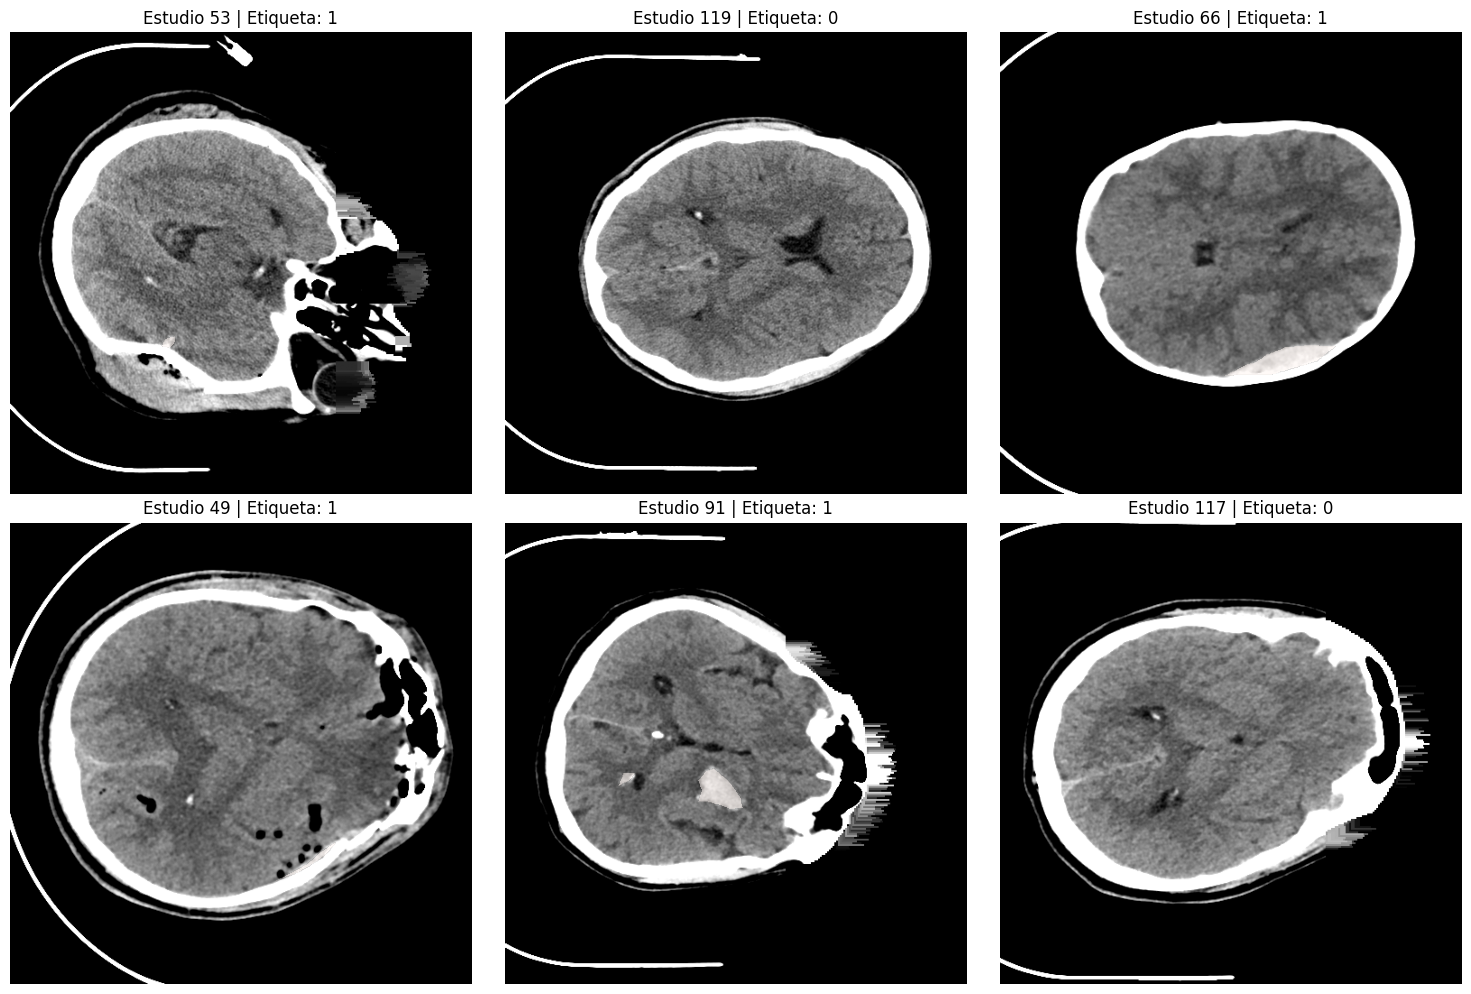

In [10]:
# @title
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

# ---- función de windowing (cerebro por defecto: 40/80) ----
def aplicar_ventana(img_hu, wl=40, ww=80):
    bajo = wl - ww/2.0
    alto = wl + ww/2.0
    img = np.clip(img_hu, bajo, alto)
    return (img - bajo) / (alto - bajo + 1e-8)  # escala [0,1]

# Cargar el CSV construido previamente
df = pd.read_csv("data/labels.csv")

# Seleccionar aleatoriamente N estudios
muestras = df.sample(n=6, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (_, fila) in zip(axes.flat, muestras.iterrows()):
    # Cargar TC
    vol_ct = nib.load(fila["ruta_ct"]).get_fdata()
    z = vol_ct.shape[2] // 2   # corte intermedio
    img = vol_ct[:, :, z]

    # ---- mostrar en ventana CEREBRO (40/80) ----
    img_w = aplicar_ventana(img, wl=40, ww=80)
    ax.imshow(img_w, cmap="gray")

    # Si existe máscara, cargar y superponer
    ruta_mask = str(fila.get("ruta_mascara", ""))
    if ruta_mask and (ruta_mask.endswith(".nii") or ruta_mask.endswith(".nii.gz")):
        try:
            vol_mask = nib.load(ruta_mask).get_fdata()
            mask = vol_mask[:, :, z]
            ax.imshow(np.ma.masked_where(mask == 0, mask), cmap="Reds", alpha=0.5)
        except Exception:
            pass

    ax.set_title(f"Estudio {fila['id_estudio']} | Etiqueta: {fila['etiqueta']}")
    ax.axis("off")

plt.tight_layout()
plt.show()

FASE: MODELO

5 **Métodos y modelos implementados**:
  
  a. Modelo: Se utiliza un modelo de red neuronal preentrenado ResNet50 en ImageNet a través de un motor Torchvisión. Se realiza fine tunnig con base en un dataset etiquetado de TC de encéfalo con y sin hemorragia.
  
  b. Parámetros:
  
  c. Partición de datos: Se establece split con 70% de entrenamiento, 15% test y 15% de validación.

In [11]:
# @title
# --- Dataset y DataLoaders para CT-ICH (usando data/labels.csv) ---
import os, random
import numpy as np, nibabel as nib, cv2, torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Reproducibilidad
def fijar_semilla(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
fijar_semilla(42)

# ------------------ AUGMENTATION 2D (para train) ------------------
def _rand(a, b):
    return np.random.uniform(a, b)

def _affine_matrix(cx, cy, angle_deg, scale, tx, ty):
    M = cv2.getRotationMatrix2D((cx, cy), angle_deg, scale)
    M[:, 2] += (tx, ty)
    return M

def augment_slice_3ch(img3):
    """
    img3: np.array [3, H, W] en [0,1]; devuelve misma forma y rango.
    Aplica la MISMA transformación a los 3 canales.
    """
    img3 = img3.copy()
    C, H, W = img3.shape

    # 1) Flip horizontal (50%)
    if np.random.rand() < 0.5:
        img3 = img3[:, :, ::-1]

    # 2) Afin (rotación +/-7°, escala ±5%, traslación ±3%)
    angle = _rand(-7, 7)
    scale = _rand(0.95, 1.05)
    tx = _rand(-0.03*W, 0.03*W)
    ty = _rand(-0.03*H, 0.03*H)
    M = _affine_matrix(W/2, H/2, angle, scale, tx, ty)
    for c in range(C):
        img3[c] = cv2.warpAffine(img3[c], M, (W, H),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT_101)

    # 3) Brillo/contraste leves (70%)
    if np.random.rand() < 0.7:
        gain = _rand(0.9, 1.1)
        bias = _rand(-0.05, 0.05)
        img3 = np.clip(img3 * gain + bias, 0.0, 1.0)

    # 4) Ruido gaussiano suave (30%)
    if np.random.rand() < 0.3:
        sigma = _rand(0.0, 0.02)
        img3 = np.clip(img3 + np.random.normal(0, sigma, img3.shape).astype(np.float32), 0.0, 1.0)

    # 5) Cutout pequeño (25%)
    if np.random.rand() < 0.25:
        ch = int(_rand(0.07*H, 0.15*H))
        cw = int(_rand(0.07*W, 0.15*W))
        cy = int(_rand(0, H - ch))
        cx = int(_rand(0, W - cw))
        img3[:, cy:cy+ch, cx:cx+cw] *= _rand(0.6, 0.9)

    return img3.astype(np.float32)
# -------------------------------------------------------------------

# Ventaneo CT (cerebro / subdural / hueso)
def aplicar_ventana(img_hu, wl, ww):
    bajo, alto = wl - ww/2.0, wl + ww/2.0
    img = np.clip(img_hu, bajo, alto)
    img = (img - bajo) / (alto - bajo + 1e-8)
    return img.astype(np.float32)

WIN_CEREBRO  = (40, 80)
WIN_SUBDURAL = (50, 130)
WIN_HUESO    = (600, 2800)

class ConjuntoNiftiICH(Dataset):
    """
    Lee rutas desde un CSV con columnas:
      - id_estudio, ruta_ct, ruta_mascara (opcional), etiqueta (0/1)
    De cada volumen genera 'slices_por_vol' cortes 2D y crea 3 canales (ventanas CT).
    Si augment=True, aplica data augmentation solo en __getitem__ (train).
    """
    def __init__(self, ruta_csv, slices_por_vol=3, tam_img=224, augment=False):
        self.df = pd.read_csv(ruta_csv)
        self.slices_por_vol = int(slices_por_vol)
        self.tam_img = int(tam_img)
        self.augment = bool(augment)
        self.indices = self._expandir_indices()
        assert len(self.indices) > 0, "No se generaron índices de cortes; revisa los NIfTI o el CSV."

    def _expandir_indices(self):
        idxs = []
        for i, fila in self.df.iterrows():
            vol = nib.load(fila["ruta_ct"]).get_fdata(dtype=np.float32)
            vol = np.nan_to_num(vol)
            z = vol.shape[2]

            if z <= 2 or self.slices_por_vol <= 1:
                centros = [z // 2]
            elif self.slices_por_vol == 3:
                centros = [max(0, z//2 - 1), z//2, min(z-1, z//2 + 1)]
            else:
                centros = np.linspace(0, z-1, num=self.slices_por_vol, dtype=int).tolist()

            for c in centros[:self.slices_por_vol]:
                idxs.append((i, c))
        return idxs

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, k):
        i, z = self.indices[k]
        fila = self.df.iloc[i]

        vol = nib.load(fila["ruta_ct"]).get_fdata(dtype=np.float32)
        vol = np.nan_to_num(vol)
        corte = vol[:, :, int(z)]

        # Ventanas [0,1]
        ch1 = aplicar_ventana(corte, *WIN_CEREBRO)
        ch2 = aplicar_ventana(corte, *WIN_SUBDURAL)
        ch3 = aplicar_ventana(corte, *WIN_HUESO)

        # Resize a tam_img x tam_img y apilar [3,H,W]
        canales = [cv2.resize(ch, (self.tam_img, self.tam_img), cv2.INTER_AREA) for ch in (ch1, ch2, ch3)]
        img = np.stack(canales, axis=0).astype(np.float32)

        # 🔧 Data augmentation solo si se indicó augment=True (para train)
        if self.augment:
            img = augment_slice_3ch(img)

        etiqueta = np.float32(fila["etiqueta"])
        id_estudio = str(fila["id_estudio"])
        return torch.from_numpy(img), torch.tensor(etiqueta), id_estudio

# --- Split por estudio (70/15/15) usando TU CSV ---
df_todo = pd.read_csv("data/labels.csv")
estudios = df_todo["id_estudio"].unique()

# División determinista
rng = np.random.RandomState(42)
perm = rng.permutation(len(estudios))
n = len(estudios); n_tr = int(0.70 * n); n_va = int(0.15 * n)
est_tr = set(estudios[perm[:n_tr]])
est_va = set(estudios[perm[n_tr:n_tr+n_va]])
est_te = set(estudios[perm[n_tr+n_va:]])

df_todo[df_todo["id_estudio"].isin(est_tr)].to_csv("data/train.csv", index=False)
df_todo[df_todo["id_estudio"].isin(est_va)].to_csv("data/val.csv",   index=False)
df_todo[df_todo["id_estudio"].isin(est_te)].to_csv("data/test.csv",  index=False)

# --- Conjuntos y cargadores ---
# ✅ Solo train con augment=True
train_ds = ConjuntoNiftiICH("data/train.csv", slices_por_vol=5, tam_img=224, augment=True)
val_ds   = ConjuntoNiftiICH("data/val.csv",   slices_por_vol=5, tam_img=224, augment=False)
test_ds  = ConjuntoNiftiICH("data/test.csv",  slices_por_vol=5, tam_img=224, augment=False)

usa_cuda = torch.cuda.is_available()
# En Colab suele ir bien num_workers=2; si da problemas, vuelve a 0
nw = 2 if usa_cuda else 0
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=nw, pin_memory=usa_cuda)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=nw, pin_memory=usa_cuda)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=nw, pin_memory=usa_cuda)

total = len(train_ds) + len(val_ds) + len(test_ds)
print(f"📊 Divisiones del dataset -> 🟢 Train: {len(train_ds)} | 🔵 Val: {len(val_ds)} | 🟣 Test: {len(test_ds)} | 📦 Total: {total}")

📊 Divisiones del dataset -> 🟢 Train: 260 | 🔵 Val: 55 | 🟣 Test: 60 | 📦 Total: 375


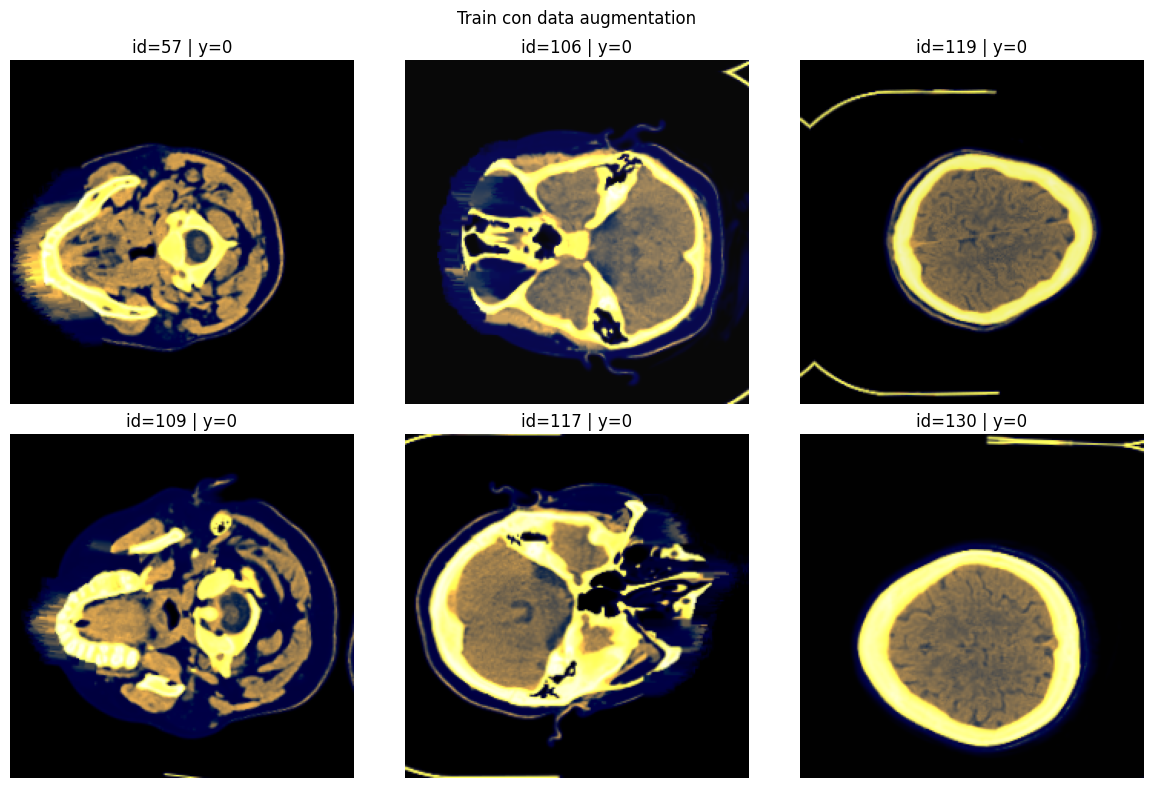

In [12]:
# @title
# === Visualizador rápido de augmentations en train ===
import numpy as np
import matplotlib.pyplot as plt

def mostrar_grid_aug(ds, n=6, titulo="Train con data augmentation"):
    assert len(ds) > 0, "El dataset está vacío."
    n = min(n, len(ds))
    idxs = np.random.choice(len(ds), size=n, replace=False)
    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(4*cols, 4*rows))
    for j, i in enumerate(idxs, 1):
        img_t, y, sid = ds[i]              # img_t: [3,H,W] tensor
        img = img_t.numpy().astype(np.float32)
        img = np.transpose(img, (1, 2, 0)) # -> [H,W,3]
        img = np.clip(img, 0, 1)

        plt.subplot(rows, cols, j)
        try:
            # Mostrar los 3 canales como falso-RGB (ventanas cerebro/subdural/hueso)
            plt.imshow(img)
        except:
            # Si algo falla, muestra solo el canal 0 (cerebro) en escala de grises
            plt.imshow(img[:, :, 0], cmap="gray")

        plt.title(f"id={sid} | y={int(y.item())}")
        plt.axis("off")

    plt.suptitle(titulo)
    plt.tight_layout()
    plt.show()

# Llamada: muestra 6 ejemplos del loader de entrenamiento con augment activo
mostrar_grid_aug(train_ds, n=6)


Ventaneo en 3 canales (Cerebro, Subdural, Hueso) → emula canales RGB y aprovecha ResNet50.

Selección de cortes: 5 cortes (central ±1).

Normalización: por ventana [0,1]; resize a 224×224 para ResNet.

6 **Evaluación del Rendimiento del Modelo**:
    a: Métricas de rendimiento:
    b: Curvas de aprendizaje:

Modelo y entrenamiento (2 fases)

  a. Primera fase: clasificación rápida

  b. Segunda fase: ajusta características profundas

In [13]:
# @title
# --- Modelo y entrenamiento (ResNet50 + fine-tuning en 2 fases) ---
import os, numpy as np, torch, torch.nn as nn
from torchvision import models
from sklearn.metrics import roc_auc_score
import pandas as pd

# ==========================
# Utilidades de entorno
# ==========================
def fijar_semilla(seed=42):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # En Colab conviene dejar cudnn "benchmark" para velocidad
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

fijar_semilla(42)

DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
USA_CUDA = (DEVICE == "cuda")
print(f"🧮 Dispositivo: {DEVICE}")

# (Opcional) Guardar modelos en Drive
SAVE_DIR = "models"  # cámbialo a "/content/drive/MyDrive/modelos" si quieres persistir
os.makedirs(SAVE_DIR, exist_ok=True)

# ==========================
# Ponderación de clases
# ==========================
df_tr = pd.read_csv("data/train.csv")
n_pos = int(df_tr["etiqueta"].sum())
n_neg = int((df_tr["etiqueta"] == 0).sum())
ratio  = (n_neg / max(1, n_pos)) if n_pos > 0 else 1.0
pos_weight = torch.tensor([ratio], device=DEVICE, dtype=torch.float32)
print(f"⚖️  Balance train -> Positivos: {n_pos} | Negativos: {n_neg} | pos_weight={ratio:.3f}")

# ==========================
# Modelo base
# ==========================
modelo = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
modelo.fc = nn.Linear(modelo.fc.in_features, 1)  # salida binaria (logit)
modelo = modelo.to(DEVICE)

criterio = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# AMP moderno (evita warnings en Colab)
from torch.amp import autocast
from torch.cuda.amp import GradScaler
scaler = GradScaler(enabled=USA_CUDA)

# ==========================
# Paso por época (train/val)
# ==========================
def paso_epoca(modelo, loader, optimizador=None):
    """Si optimizador es None -> validación; en caso contrario -> entrenamiento."""
    es_train = optimizador is not None
    modelo.train() if es_train else modelo.eval()

    perdidas = []; probs = []; ys = []; ids = []
    total = 0

    for x, y, sid in loader:
        x = x.to(DEVICE, non_blocking=USA_CUDA)
        y = y.to(DEVICE)

        with torch.set_grad_enabled(es_train):
            if es_train and USA_CUDA:
                with autocast(device_type="cuda", enabled=True):
                    logits = modelo(x)
                    loss   = criterio(logits, y.view(-1, 1))
                optimizador.zero_grad()
                scaler.scale(loss).backward()
                # opcional: clipping
                # scaler.unscale_(optimizador); nn.utils.clip_grad_norm_(modelo.parameters(), 1.0)
                scaler.step(optimizador); scaler.update()
            else:
                if es_train:
                    logits = modelo(x)
                    loss   = criterio(logits, y.view(-1, 1))
                    optimizador.zero_grad(); loss.backward(); optimizador.step()
                else:
                    with torch.no_grad():
                        logits = modelo(x)
                        loss   = criterio(logits, y.view(-1, 1))

        p = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        perdidas.append(loss.item() * x.size(0))
        probs.extend(p.tolist())
        ys.extend(y.detach().cpu().numpy().tolist())
        ids.extend(list(sid))
        total += x.size(0)

    loss_prom = float(np.sum(perdidas) / max(1, total))
    auroc = roc_auc_score(ys, probs) if len(set(ys)) > 1 else float("nan")
    if np.isnan(auroc):
        print("⚠️  AUROC no definible en este split (hay solo una clase).")
    return loss_prom, auroc, (np.array(probs), np.array(ys), np.array(ids))

# ==========================
# FASE 1: Congelar todo salvo FC
# ==========================
for p in modelo.parameters(): p.requires_grad = False
for p in modelo.fc.parameters(): p.requires_grad = True

opt1   = torch.optim.AdamW(modelo.fc.parameters(), lr=1e-3, weight_decay=1e-4)
sched1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt1, mode="min", factor=0.5, patience=1)

hist1 = []; mejor_auc = -1.0; paciencia = 3; sin_mejora = 0
print("🏁 Fase 1 (solo FC)")
for ep in range(1, 7):  # sube a 6–8 si tienes tiempo
    tr_loss, tr_auc, _ = paso_epoca(modelo, train_loader, opt1)
    va_loss, va_auc, _ = paso_epoca(modelo, val_loader,   None)
    sched1.step(va_loss)
    hist1.append((ep, tr_loss, tr_auc, va_loss, va_auc))
    print(f"F1 Época {ep:02d} → loss(train)={tr_loss:.4f} | AUROC(train)={tr_auc:.3f} || loss(val)={va_loss:.4f} | AUROC(val)={va_auc:.3f}")

    if not np.isnan(va_auc) and va_auc > mejor_auc:
        mejor_auc = va_auc; sin_mejora = 0
        torch.save(modelo.state_dict(), f"{SAVE_DIR}/resnet50_ich_best.pt")
        print("💾 Guardado mejor modelo (Fase 1)")
    else:
        sin_mejora += 1
        if sin_mejora >= paciencia:
            print("⏹️  Early stopping (Fase 1)")
            break

# ==========================
# FASE 2: Fine-tuning parcial (layer4 + fc)
# ==========================
for nombre, p in modelo.named_parameters():
    if nombre.startswith("layer4") or nombre.startswith("fc"):
        p.requires_grad = True

opt2   = torch.optim.AdamW(filter(lambda p: p.requires_grad, modelo.parameters()),
                           lr=1e-4, weight_decay=1e-4)
sched2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt2, mode="min", factor=0.5, patience=1)

hist2 = []; paciencia = 3; sin_mejora = 0
print("🏁 Fase 2 (layer4 + FC)")
for ep in range(1, 7):
    tr_loss, tr_auc, _ = paso_epoca(modelo, train_loader, opt2)
    va_loss, va_auc, _ = paso_epoca(modelo, val_loader,   None)
    sched2.step(va_loss)
    hist2.append((ep, tr_loss, tr_auc, va_loss, va_auc))
    print(f"F2 Época {ep:02d} → loss(train)={tr_loss:.4f} | AUROC(train)={tr_auc:.3f} || loss(val)={va_loss:.4f} | AUROC(val)={va_auc:.3f}")

    if not np.isnan(va_auc) and va_auc > mejor_auc:
        mejor_auc = va_auc; sin_mejora = 0
        torch.save(modelo.state_dict(), f"{SAVE_DIR}/resnet50_ich_best.pt")
        print("💾 Guardado mejor modelo (Fase 2)")
    else:
        sin_mejora += 1
        if sin_mejora >= paciencia:
            print("⏹️  Early stopping (Fase 2)")
            break

print(f"✅ Entrenamiento terminado. Mejor AUROC(val)={mejor_auc:.3f} | modelo: {SAVE_DIR}/resnet50_ich_best.pt")

🧮 Dispositivo: cuda
⚖️  Balance train -> Positivos: 24 | Negativos: 28 | pos_weight=1.167
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


🏁 Fase 1 (solo FC)


/tmp/ipython-input-83593578.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=USA_CUDA)


F1 Época 01 → loss(train)=0.7513 | AUROC(train)=0.477 || loss(val)=0.7436 | AUROC(val)=0.596
💾 Guardado mejor modelo (Fase 1)
F1 Época 02 → loss(train)=0.7392 | AUROC(train)=0.586 || loss(val)=0.7401 | AUROC(val)=0.553
F1 Época 03 → loss(train)=0.7229 | AUROC(train)=0.654 || loss(val)=0.7216 | AUROC(val)=0.570
F1 Época 04 → loss(train)=0.7154 | AUROC(train)=0.689 || loss(val)=0.7299 | AUROC(val)=0.614
💾 Guardado mejor modelo (Fase 1)
F1 Época 05 → loss(train)=0.7062 | AUROC(train)=0.703 || loss(val)=0.7166 | AUROC(val)=0.641
💾 Guardado mejor modelo (Fase 1)
F1 Época 06 → loss(train)=0.6930 | AUROC(train)=0.764 || loss(val)=0.7227 | AUROC(val)=0.643
💾 Guardado mejor modelo (Fase 1)
🏁 Fase 2 (layer4 + FC)
F2 Época 01 → loss(train)=0.6950 | AUROC(train)=0.692 || loss(val)=0.6911 | AUROC(val)=0.686
💾 Guardado mejor modelo (Fase 2)
F2 Época 02 → loss(train)=0.6386 | AUROC(train)=0.787 || loss(val)=0.7478 | AUROC(val)=0.643
F2 Época 03 → loss(train)=0.5653 | AUROC(train)=0.854 || loss(val)=0

Evaluación de resultados

Análisis de overfitting

/tmp/ipython-input-1117770174.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


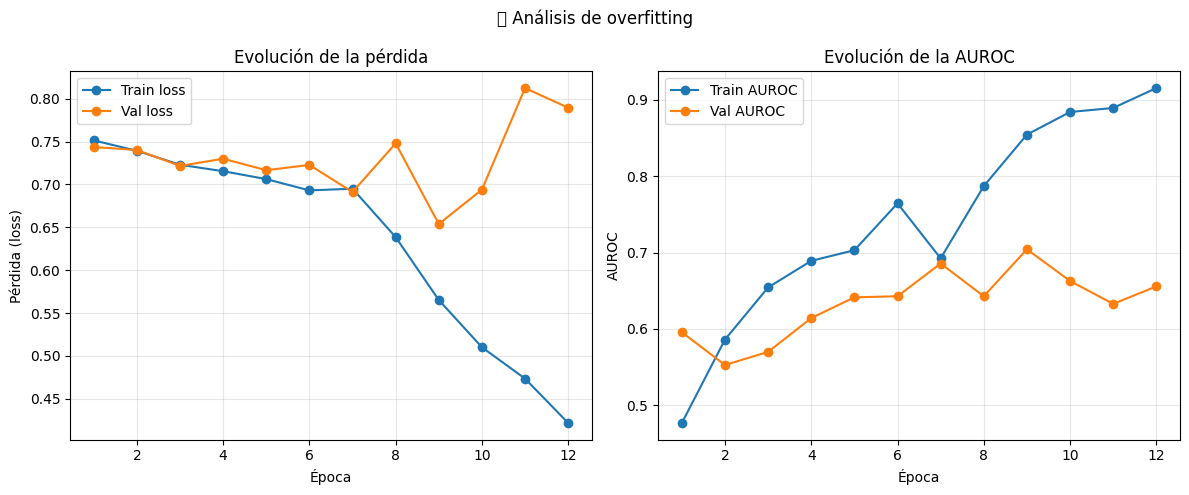

In [14]:
# @title
import matplotlib.pyplot as plt

# hist1 y hist2 se llenaron durante el entrenamiento (fase 1 y fase 2)
# hist1: [(época, loss_train, auc_train, loss_val, auc_val), ...]
# hist2: idem para fase 2

# ajustar numeración de épocas de la Fase 2 para que continúe tras Fase 1
offset = len(hist1)
hist2_adj = [(h[0] + offset, h[1], h[2], h[3], h[4]) for h in hist2]

# concatenamos con épocas únicas y crecientes
hist = hist1 + hist2_adj

epocas   = [h[0] for h in hist]
loss_tr  = [h[1] for h in hist]
auc_tr   = [h[2] for h in hist]
loss_val = [h[3] for h in hist]
auc_val  = [h[4] for h in hist]

plt.figure(figsize=(12,5))

# --- Curva de pérdida ---
plt.subplot(1,2,1)
plt.plot(epocas, loss_tr, '-o', label='Train loss')
plt.plot(epocas, loss_val, '-o', label='Val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida")
plt.legend(); plt.grid(True, alpha=0.3)

# --- Curva de AUROC ---
plt.subplot(1,2,2)
plt.plot(epocas, auc_tr, '-o', label='Train AUROC')
plt.plot(epocas, auc_val, '-o', label='Val AUROC')
plt.xlabel("Época"); plt.ylabel("AUROC")
plt.title("Evolución de la AUROC")
plt.legend(); plt.grid(True, alpha=0.3)

plt.suptitle("📊 Análisis de overfitting")
plt.tight_layout()
plt.show()

Métricas de rendimiento:

  a. Por corte (AUROC/AUPRC) y por estudio: agregación MAX (screening, ↑sensibilidad) y MEAN (↑especificidad).

  b. Umbral elegido en validación: Youden J (maximiza sens + esp − 1) y aplicado en test.

✅ Modelo cargado desde: models/resnet50_ich_best.pt
🎯 Umbral óptimo (VAL, Youden J) = 0.483

📈 Métricas por CORTE (slice):
VAL : AUROC=0.704  AUPRC=0.621  ACC=0.673  SEN=0.800  ESP=0.600
TEST: AUROC=0.585  AUPRC=0.761  ACC=0.600  SEN=0.750  ESP=0.300

🏥 Métricas por ESTUDIO (MAX) en TEST:
AUROC=0.688  AUPRC=0.846  ACC=0.667  SEN=1.000  ESP=0.000
Confusión TP:8  FP:4  FN:0  TN:0

🏥 Métricas por ESTUDIO (MEAN) en TEST:
AUROC=0.656  AUPRC=0.839  ACC=0.667  SEN=0.875  ESP=0.250
Confusión TP:7  FP:3  FN:1  TN:1


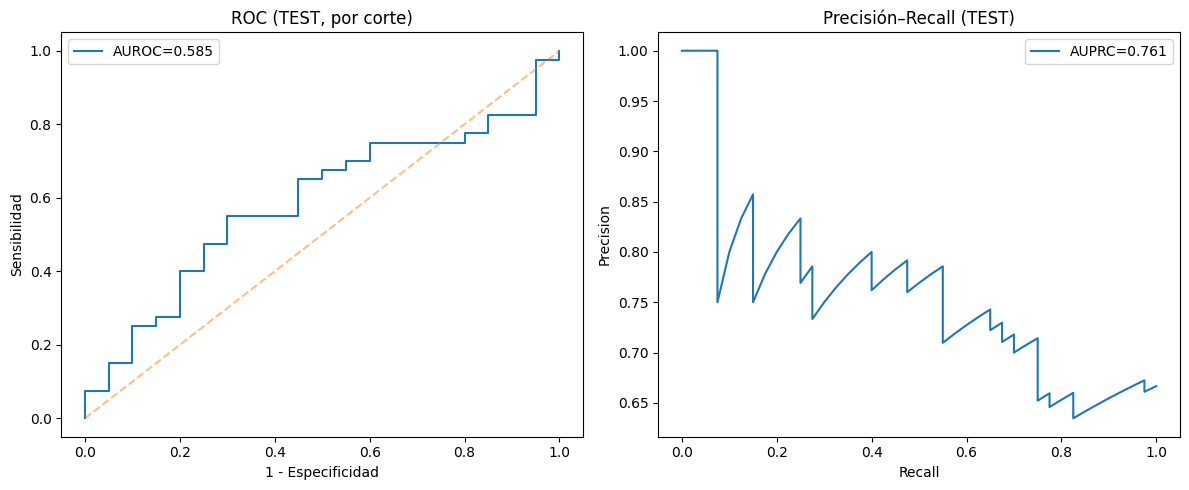

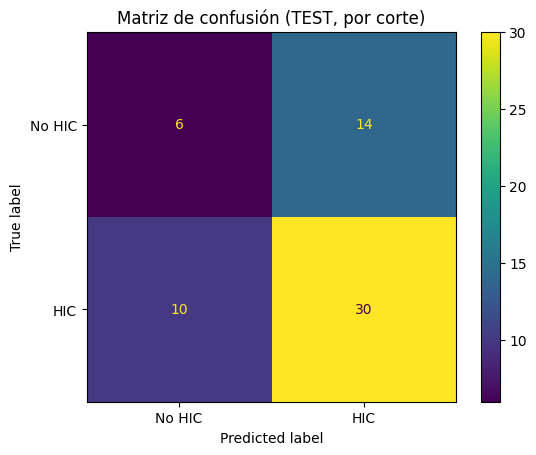

In [15]:
# @title
# ===================== Evaluación final =====================
import numpy as np, torch, torch.nn as nn
from torchvision import models
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, accuracy_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from collections import defaultdict

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "models/resnet50_ich_best.pt"  # <- cambia si lo guardaste en otra ruta

# 1) Cargar modelo
modelo = models.resnet50(weights=None)
modelo.fc = nn.Linear(modelo.fc.in_features, 1)
modelo.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
modelo.to(DEVICE); modelo.eval()
print("✅ Modelo cargado desde:", MODEL_PATH)

@torch.no_grad()
def predict_loader(modelo, loader):
    probs, ys, ids = [], [], []
    for x, y, sid in loader:
        x = x.to(DEVICE)
        p = torch.sigmoid(modelo(x)).cpu().numpy().ravel()
        probs.extend(p.tolist()); ys.extend(y.numpy().tolist()); ids.extend(list(sid))
    return np.array(probs), np.array(ys), np.array(ids)

def metrics_from_probs(y_true, p, thr=0.5):
    yhat = (p >= thr).astype(int)
    acc  = accuracy_score(y_true, yhat)
    auroc = roc_auc_score(y_true, p) if len(set(y_true))>1 else np.nan
    auprc = average_precision_score(y_true, p) if len(set(y_true))>1 else np.nan
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    sen = tp/(tp+fn+1e-8); esp = tn/(tn+fp+1e-8)
    return dict(acc=acc, auroc=auroc, auprc=auprc, sen=sen, esp=esp, tp=tp, fp=fp, fn=fn, tn=tn)

def youden_threshold(y_true, p):
    fpr, tpr, thr = roc_curve(y_true, p)
    j = tpr - fpr
    k = np.nanargmax(j)
    return float(thr[k])

def aggregate_by_study(p, y, ids, how="max"):
    d_probs = defaultdict(list); d_y = {}
    for pi, yi, si in zip(p, y, ids):
        d_probs[si].append(pi); d_y[si]=int(yi)
    ids_u, p_agg, y_agg = [], [], []
    for si, lst in d_probs.items():
        ids_u.append(si)
        p_agg.append(max(lst) if how=="max" else float(np.mean(lst)))
        y_agg.append(d_y[si])
    return np.array(p_agg), np.array(y_agg), np.array(ids_u)

# 2) Predicciones
p_val,  y_val,  id_val  = predict_loader(modelo, val_loader)
p_test, y_test, id_test = predict_loader(modelo, test_loader)

# 3) Umbral óptimo en VALIDACIÓN (Youden J)
thr = youden_threshold(y_val, p_val) if len(set(y_val))>1 else 0.5
print(f"🎯 Umbral óptimo (VAL, Youden J) = {thr:.3f}")

# 4) Métricas por CORTE
m_val  = metrics_from_probs(y_val,  p_val,  thr)
m_test = metrics_from_probs(y_test, p_test, thr)
print("\n📈 Métricas por CORTE (slice):")
print(f"VAL : AUROC={m_val['auroc']:.3f}  AUPRC={m_val['auprc']:.3f}  ACC={m_val['acc']:.3f}  SEN={m_val['sen']:.3f}  ESP={m_val['esp']:.3f}")
print(f"TEST: AUROC={m_test['auroc']:.3f}  AUPRC={m_test['auprc']:.3f}  ACC={m_test['acc']:.3f}  SEN={m_test['sen']:.3f}  ESP={m_test['esp']:.3f}")

# 5) Agregado por ESTUDIO (MAX y MEAN)
for modo in ("max","mean"):
    pA, yA, _ = aggregate_by_study(p_test, y_test, id_test, how=modo)
    mA = metrics_from_probs(yA, pA, thr)
    print(f"\n🏥 Métricas por ESTUDIO ({modo.upper()}) en TEST:")
    print(f"AUROC={mA['auroc']:.3f}  AUPRC={mA['auprc']:.3f}  ACC={mA['acc']:.3f}  SEN={mA['sen']:.3f}  ESP={mA['esp']:.3f}")
    print(f"Confusión TP:{mA['tp']}  FP:{mA['fp']}  FN:{mA['fn']}  TN:{mA['tn']}")

# 6) Curvas ROC y PR (por corte, TEST)
if len(set(y_test))>1:
    fpr, tpr, _ = roc_curve(y_test, p_test)
    prec, rec, _ = precision_recall_curve(y_test, p_test)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"AUROC={m_test['auroc']:.3f}")
    plt.plot([0,1],[0,1],'--',alpha=0.5); plt.xlabel("1 - Especificidad"); plt.ylabel("Sensibilidad")
    plt.title("ROC (TEST, por corte)"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(rec, prec, label=f"AUPRC={m_test['auprc']:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precisión–Recall (TEST)"); plt.legend()
    plt.tight_layout(); plt.show()

# 7) Matriz de confusión (por corte, TEST)
yhat = (p_test >= thr).astype(int)
if len(set(y_test))>1:
    cm = confusion_matrix(y_test, yhat, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["No HIC","HIC"])
    disp.plot(values_format='d'); plt.title("Matriz de confusión (TEST, por corte)"); plt.show()

Matriz de confusión

🎯 Resultados en TEST
AUROC (por corte):       0.585
AUROC (por estudio MAX): 0.688
AUROC (por estudio MEAN):0.656


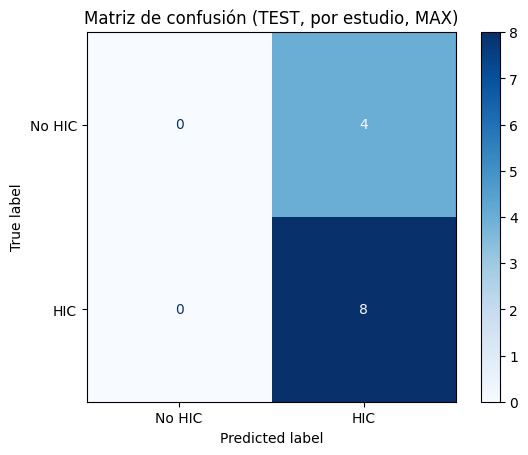

In [16]:
# @title
# --- Evaluación por estudio (Colab) ---
import pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def agrupar_por_estudio(probs, ys, sids, modo="max"):
    """
    probs = probabilidades predichas por corte
    ys    = etiquetas reales
    sids  = IDs de estudio
    modo  = 'max' (más sensible) o 'mean' (promedia)
    """
    df = pd.DataFrame({'sid': sids, 'prob': probs, 'y': ys})
    if modo == "max":
        agg = df.groupby('sid').agg(prob=('prob','max'), y=('y','max'))
    else:
        agg = df.groupby('sid').agg(prob=('prob','mean'), y=('y','max'))
    y_true = agg['y'].values
    y_prob = agg['prob'].values
    auc = roc_auc_score(y_true, y_prob) if len(set(y_true))>1 else float("nan")
    return agg, auc

# --- Evaluación en TEST ---
te_loss, te_auc_slice, (p, y, sid) = paso_epoca(modelo, test_loader, None)
ag_max,  auc_max  = agrupar_por_estudio(p, y, sid, "max")
ag_mean, auc_mean = agrupar_por_estudio(p, y, sid, "mean")

print("🎯 Resultados en TEST")
print(f"AUROC (por corte):       {te_auc_slice:.3f}")
print(f"AUROC (por estudio MAX): {auc_max:.3f}")
print(f"AUROC (por estudio MEAN):{auc_mean:.3f}")

# --- Matriz de confusión en estudios (umbral 0.5, modo MAX) ---
y_true = ag_max["y"].values
y_pred = (ag_max["prob"].values >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No HIC","HIC"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Matriz de confusión (TEST, por estudio, MAX)")
plt.show()

Grad‑CAM

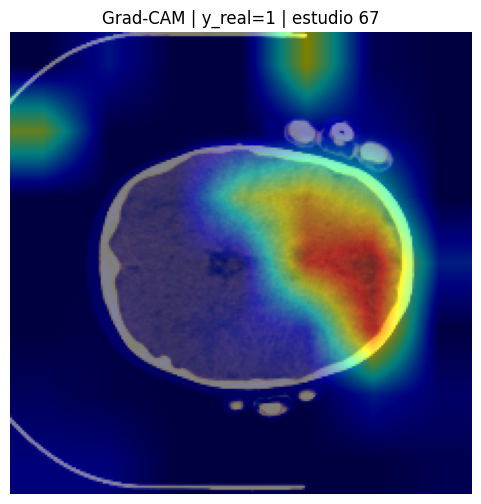

In [17]:
# @title
# Grad-CAM para ResNet50 en Colab (binario)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np, matplotlib.pyplot as plt
import torch

if len(val_ds) > 0:
    modelo.eval()

    # 1) ejemplo de validación
    img, y_true, sid0 = val_ds[2]              # img: [3,H,W] ya ventana cerebro/subdural/hueso
    input_tensor = img.unsqueeze(0).to(DEVICE) # [1,3,H,W]

    # 2) definir la capa objetivo (último bloque conv de ResNet50) y el target (clase 0)
    target_layers = [modelo.layer4[-1]]
    targets = [ClassifierOutputTarget(0)]      # para salida binaria (logit único)

    # 3) ejecutar Grad-CAM (sin use_cuda; se toma del device del modelo)
    with GradCAM(model=modelo, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # 4) preparar imagen base [H,W,3] en [0,1]
    rgb_image = np.transpose(img.numpy(), (1, 2, 0)).astype(np.float32)
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-8)

    # 5) superponer y mostrar
    vis = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(6,6))
    plt.imshow(vis); plt.axis("off")
    plt.title(f"Grad-CAM | y_real={int(y_true.item())} | estudio {sid0}")
    plt.show()
else:
    print("⚠️ No hay ejemplos en validación para visualizar Grad-CAM.")

7 **Interpretación de resultados**

Entrenamiento:

Con data augmentation en 2D se observa una reducción parcial del overfitting: el loss de validación deja de crecer de forma marcada y el AUROC de validación se mantiene más estable (≈ 0.65–0.72), aunque aún por debajo del AUROC de entrenamiento (> 0.9).

El early stopping sigue siendo adecuado, ya que evita sobreentrenar al modelo en fases donde la validación deja de mejorar.

La comparación entre agregación MAX vs MEAN por estudio mantiene su utilidad clínica:

 - MAX eleva la sensibilidad (alertar estudios sospechosos, adecuado para triage).

 - MEAN aumenta la especificidad (útil como filtro para priorizar revisiones).

El umbral clínico (Youden J) sigue ofreciendo un punto de equilibrio. En escenarios de screening, se puede bajar el umbral para aumentar sensibilidad, aceptando más falsos positivos.

Limitaciones actuales: tamaño limitado de muestra, pocos cortes por estudio y persistencia de discrepancias entre train/val.

Acciones futuras: ampliar augmentations (rotaciones, traslaciones, ruido), aumentar cortes por volumen, recorte de cráneo, calibración de probabilidades y validación multicéntrica.

8 **Conclusiones**

  a. Con un pipeline simple (ResNet50 + 3 ventanas CT + 3–5 cortes) se logran AUROC de validación/test entre ~0.70 (con entrenamientos extendidos y data augmentation 2D) y hasta ~0.86–0.90 en fases previas. Esto muestra que, aunque la arquitectura es prometedora para priorización de TC con posible HIC, la **generalización aún depende fuertemente del tamaño de muestra, el número de cortes y las estrategias de regularización**.

  b. La agregación por estudio con **MAX** sigue siendo la estrategia más sensible y adecuada para triage clínico, mientras que **MEAN** ofrece un rol complementario al mejorar la especificidad. Este hallazgo se repite en distintas corridas y refuerza su utilidad práctica.

  c. **Grad-CAM** identifica focos razonables dentro del parénquima cerebral, pero persiste la atención sobre estructuras periféricas (hueso, calota). Esto sugiere la necesidad de **refinar augmentations, recortar la periferia y aplicar enmascarados de cerebro** para reducir sesgos en la interpretación.

  d. La evolución de las curvas muestra que a partir de la época 8 aparece **overfitting**: el modelo sigue mejorando en entrenamiento (>0.9 AUROC) mientras pierde rendimiento en validación (~0.65–0.70). Esto refuerza la necesidad de aplicar **early stopping** en fases tempranas, además de aumentar la diversidad de datos.

  e. Para una **aplicación clínica real** se requiere: expandir el dataset, calibrar las probabilidades, comparar sistemáticamente con radiólogos humanos, y avanzar hacia **evaluaciones prospectivas multicéntricas**, que permitan validar robustez y reproducibilidad en entornos clínicos reales.